Jupyter Notebook to compare median income to ufo sighting trends

In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from matplotlib import rcParams

# Dictionary to convert state names to their abbreviations
from us_state_abbrev import us_state_abbrev
################################################
# Title: us_state_abbrev.py
# Author: Haque, A
# Date: 2016
# Availability: https://gist.github.com/afhaque/29f0f4f37463c447770517a6c17d08f5#file-us_state_abbrev-py
################################################

In [2]:
# Import median income csv file, convert to dataframe and clean

income_df = pd.read_csv("Resources/household_median_income_2017.csv")
# Data from https://data.world/garyhoov/household-income-by-state
income_df = income_df.dropna()
income_df = income_df.drop([0])
# Washington DC is removed because the ufo data was incomplete
income_df = income_df.drop([9])

# Convert state names to abbreviations for merging with ufo dataframe
for index, row in income_df.iterrows():
    row["State"] = us_state_abbrev[row["State"]]
    
income_df.head()

,State,2017,2016,2015,2014,2013,2013.1,2012,2011,2010,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
1,AL,"51,113","48,237","46,053","43,820","49,876","43,616","46,490","46,520","46,120",...,"42,017","44,323","42,852","42,607","40,740","39,852","40,848","40,965","39,941","39,007"
2,AK,"72,231","77,351","77,717","70,095","76,387","64,439","68,080","62,731","65,178",...,"71,917","71,791","71,482","71,686","68,919","66,133","68,791","67,138","75,777","72,912"
3,AZ,"61,125","58,328","54,060","51,050","55,453","53,335","50,320","53,108","52,839",...,"51,110","50,420","54,101","53,309","54,651","52,811","55,369","54,600","52,019","48,280"
4,AR,"48,829","46,894","44,282","46,560","41,503","42,075","41,735","45,114","43,477",...,"38,594","41,015","41,248","41,565","41,025","40,299","38,971","40,104","38,019","35,320"
5,CA,"69,759","68,070","65,843","62,693","64,078","60,635","60,990","58,292","61,162",...,"57,078","59,943","59,253","60,726","63,183","60,507","62,401","62,115","58,782","56,983"


In [3]:
# Import the clean ufo data

ufo_df = pd.read_csv("Resources/usa_sights.csv")

# Keep only the columns needed for this analysis
ufo_df = ufo_df[["state", "sightings", "year"]]

# Format ufo dataframe for merging with income dataframe
ufo_df["state"] = ufo_df["state"].str.upper()
ufo_df = ufo_df.rename(columns={"state": "State", "sightings": "Sightings", "year": "Year"})

ufo_df.head()

,State,Sightings,Year
0,TX,1,1949
1,TX,1,1956
2,HI,1,1960
3,TN,1,1961
4,CT,1,1965


/Users/adamburstyn/opt/anaconda3/envs/pythondata/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/Users/adamburstyn/opt/anaconda3/envs/pythondata/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/Users/adamburstyn/opt/anaconda3/envs/pythondata/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: 

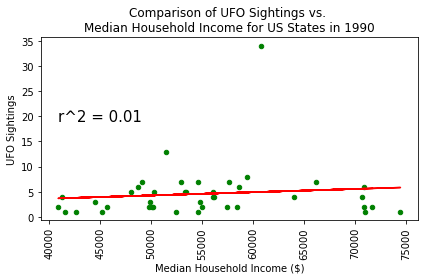

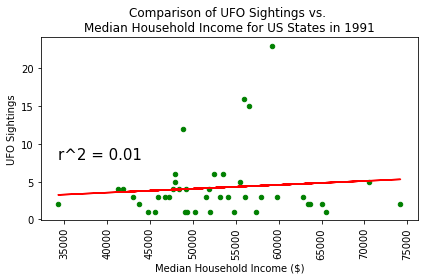

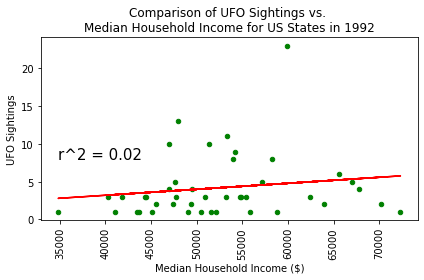

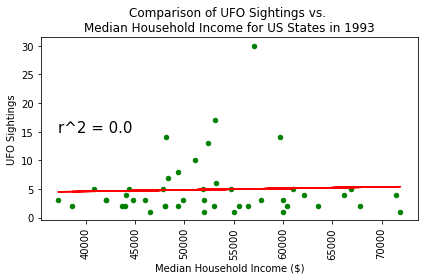

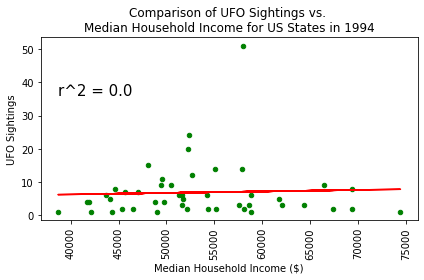

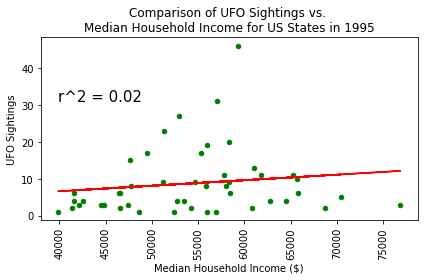

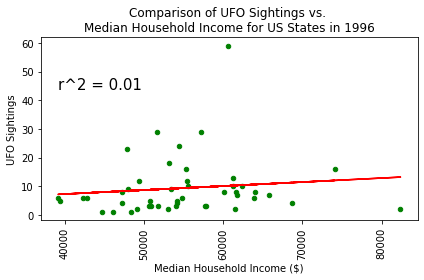

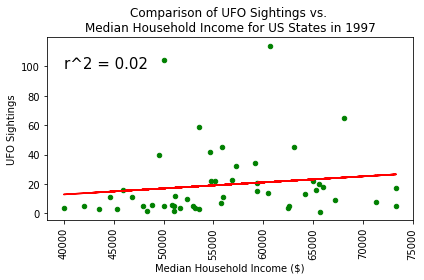

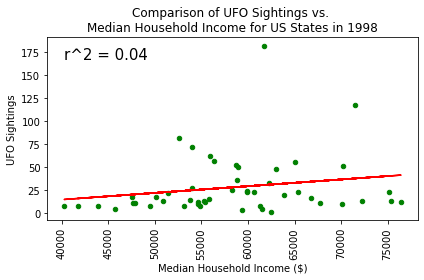

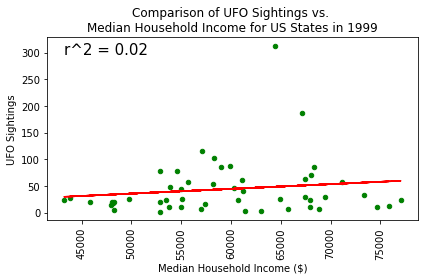

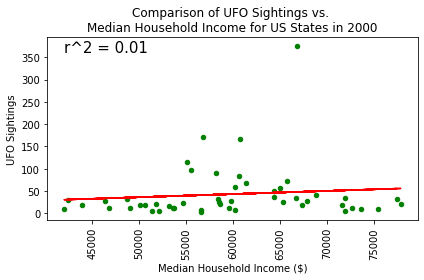

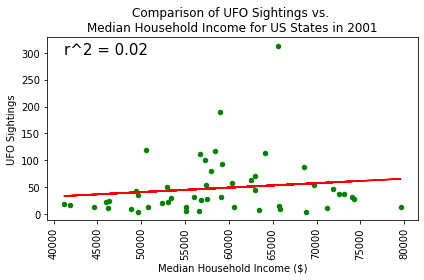

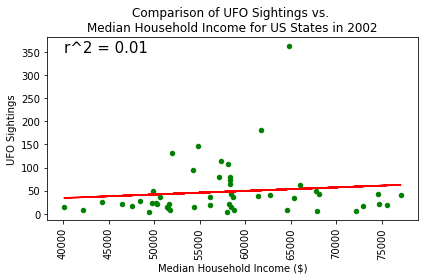

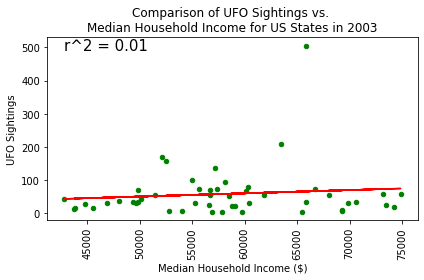

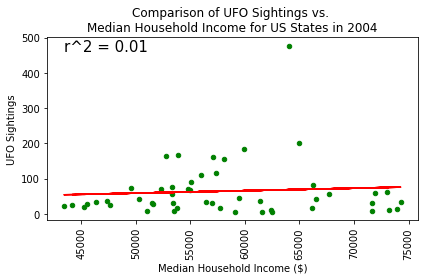

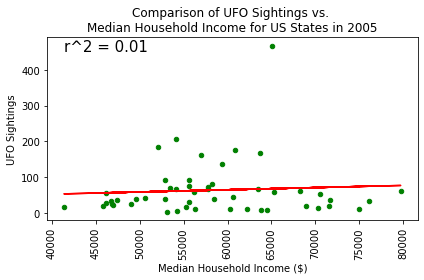

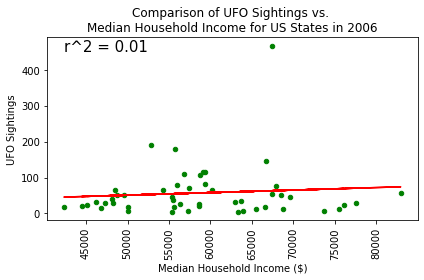

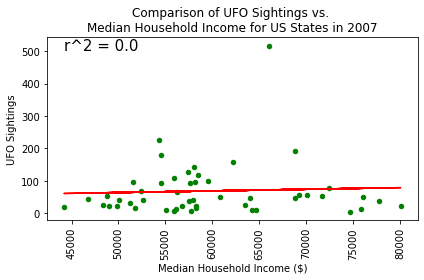

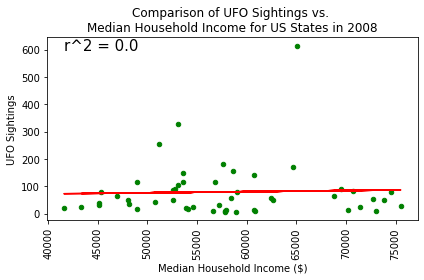

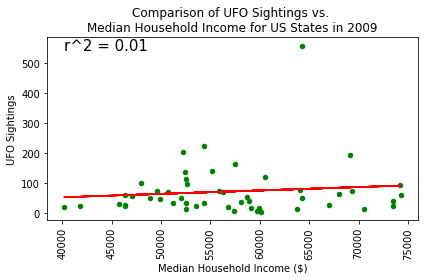

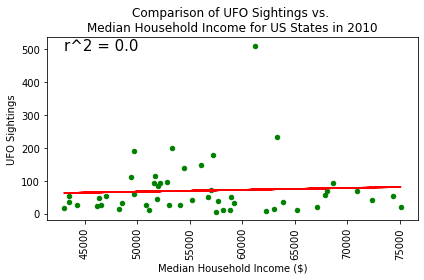

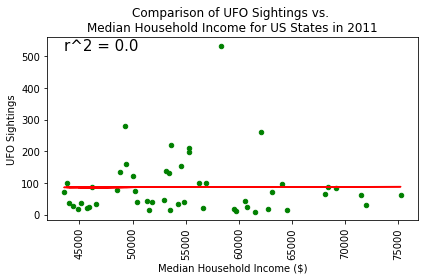

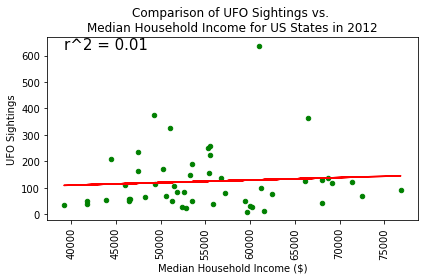

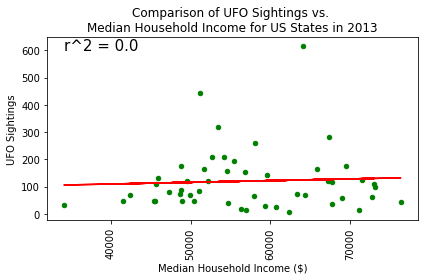

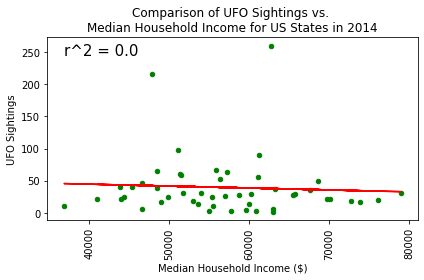

In [4]:
# Iterate through years to make all comparisons
for year in range(1990, 2015):

    # Get the income for the year iteration
    incomeYear = income_df[["State", f"{year}"]]
    incomeYear = incomeYear.rename(columns={f"{year}": "Income"})

    # Convert income to float for graphing and calculating regression line
    incomeYear["Income"] = incomeYear["Income"].str.replace(',','').astype(float)

    # Get only the year iteration data from the ufo dataframe
    ufoYear = ufo_df.loc[ufo_df["Year"]==year]
    ufoYear = ufoYear[["State", "Sightings"]]
    ufoYear = ufoYear.groupby("State").sum()

    # Merge income with ufo data frame
    incomeYear = pd.merge(incomeYear, ufoYear, on="State")
    incomeYear.set_index("State", inplace = True)

    # Perform linear regression calculations
    (slope, intercept, rvalue, pvalue, sterr) = linregress(incomeYear["Income"], incomeYear["Sightings"])
    line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

    # Create the scatter plot
    rcParams.update({'figure.autolayout': True})
    incomeYear.plot(kind="scatter", y="Sightings", x="Income", c="g", 
               title = f"Comparison of UFO Sightings vs. \nMedian Household Income for US States in {year}")
    regressValues = (slope*incomeYear["Income"]) + intercept
    plt.plot(incomeYear["Income"], regressValues,"red")
    plt.annotate(f"r^2 = {round(rvalue**2,2)}",(incomeYear["Income"].min()+5,incomeYear["Sightings"].max()-15),fontsize=15,color="black")
    plt.xticks(rotation=90)
    plt.xlabel("Median Household Income ($)")
    plt.ylabel("UFO Sightings")
    plt.savefig(f"Income_Graphs/income_ufo_{year}.png")